# TEDx Scraper


This scraper downloads more than 4k talks from www.ted.com
in order to create a dataset for research purporse.

The main dataset is composed by the following attributes:
- unique id
- details
- posted
- main_speaker
- event
- title
- num_views
- url

The tags dataset is composed by the following attributes (linked 1-n with the main dataset):
- unique id
- tag

The "watch next" dataset is composed by the following attributes:
- id
- watch_next_id


The  is organized with the following sections:

- Setup of the env (install libraries, set up variables and credentials, ...)
- Download of the index (with Selenium and Chrome Browser libraries + API)
- Store the data on CSV files

### Setup of the env

Install and import of python libraries

In [1]:
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
sudo apt-get install -f

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,533 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,934 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-update

In [2]:
!pip install chromedriver-py
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 28.8 MB/s eta 0:00:00


In [3]:
import sys
import logging
from selenium.webdriver.remote.remote_connection import LOGGER
LOGGER.setLevel(logging.WARNING)
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from tqdm.notebook import tqdm
import pandas as pd
import time
import hashlib
import json
import pprint
from chromedriver_py import binary_path
import requests


Set the following variables to download data:

- max_page: max number of pages to loop (set to -1 to download all the pages)
- sleep_time: to be polite with TEDx (number of seconds between different request)




In [4]:
max_page = 300
sleep_time = 1
log = False

In [5]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("window-size=1900,800")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36")

In [6]:
def get_browser():
    service = Service(executable_path=binary_path)
    wd = webdriver.Chrome(service=service, options=chrome_options)
    return wd

browser = get_browser()

def talks_page():
    url = 'https://www.ted.com/talks?sort=newest'
    print(f'Navigate to {url}')
    browser.get(url)
    time.sleep(sleep_time * 4)
    try:
      cookie_btn = browser.find_elements(By.ID, 'onetrust-accept-btn-handler')
      cookie_btn.click()
    except:
      pass
    time.sleep(sleep_time)

talks_page()

Navigate to https://www.ted.com/talks?sort=newest


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


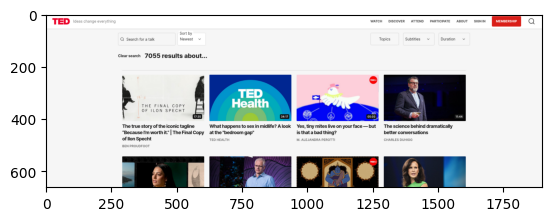

In [7]:
browser.save_screenshot('screenshot.png')

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/screenshot.png')
imgplot = plt.imshow(img)
plt.show()

In [8]:
final = []

# Get TEDx data


First of all we will take all the data using API. We will simulate the navigation in the web site and we will download the data for all the TED Talks.

In [17]:
payload = [
        {"indexName":"newest",
         "params":{"attributeForDistinct": "objectID",
                   "distinct": 1,
                   "facets": ["subtitle_languages","tags"],
                   "highlightPostTag": "__/ais-highlight__",
                   "highlightPreTag": "__ais-highlight__",
                   "hitsPerPage": 24,
                   "maxValuesPerFacet": 500,
                   "page": 14,"query": "",
                   "tagFilters": ""
                  }
        }
    ]
r = requests.post('https://zenith-prod-alt.ted.com/api/search',
                  headers={'Content-type': 'application/json; charset=UTF-8',
                            "User-Agent": "curl/7.64.1"},
                json=payload)

In [18]:
my_tedx = r.json()['results'][0]["hits"]

In [19]:
import time
for page in tqdm(range(0, max_page)):
    time.sleep(0.2)
    payload = [
        {"indexName":"newest",
         "params":{"attributeForDistinct": "objectID",
                   "distinct": 1,
                   "facets": ["subtitle_languages","tags"],
                   "highlightPostTag": "__/ais-highlight__",
                   "highlightPreTag": "__ais-highlight__",
                   "hitsPerPage": 24,
                   "maxValuesPerFacet": 500,
                   "page": page,"query": "",
                   "tagFilters": ""
                  }
        }
    ]
    r = requests.post('https://zenith-prod-alt.ted.com/api/search',
                      headers={'Content-type': 'application/json; charset=UTF-8',
                               "User-Agent": "curl/7.64.1"},
                    json=payload)
    my_tedx = r.json()['results'][0]["hits"]
    final.extend(my_tedx)

  0%|          | 0/300 [00:00<?, ?it/s]

In [20]:
final[0]

{'objectID': '567505',
 '_index': 'coyote_models_acme_videos_index_1705009781900',
 '_score': None,
 'duration': '1055.68',
 'speakers': 'Ben Proudfoot',
 'title': 'The true story of the iconic tagline “Because I’m worth it.” | The Final Copy of Ilon Specht',
 'photos': [{'updated_at': '2025-02-27T15:30:11.000Z',
   'description': 'Set 1',
   'created_at': '2025-02-27T15:30:11.000Z',
   'id': 164779,
   'photo_sizes': [{'talkstar_photo_id': 164779,
     'updated_at': '2025-02-28T20:25:53.000Z',
     'width': 1920,
     'created_at': '2025-02-27T15:31:56.000Z',
     'id': 293409,
     'talkstar_aspect_ratio_id': 2,
     'url': 'https://talkstar-assets.s3.amazonaws.com/production/talks/talk_147074/db4647e7-5544-4b4e-a33c-144e62855770/Ilon_Specht_16x9.jpg',
     'height': 1080},
    {'talkstar_photo_id': 164779,
     'updated_at': '2025-02-28T20:25:53.000Z',
     'width': 1000,
     'created_at': '2025-02-27T15:31:56.000Z',
     'id': 293410,
     'talkstar_aspect_ratio_id': 36,
     'url

We have more than 6k talks:

In [22]:
len(final)

7967

with this structure:

Now we will parse the result:

In [23]:
final_list = []
for talk in final:
  slug = talk["slug"]
  final_list.append({
      'id': talk["objectID"],
      'slug': talk["slug"],
      'speakers': talk["speakers"],
      'title': talk["title"],
      "url": f'https://www.ted.com/talks/{slug}'
  })

In [24]:
final_list[0]

{'id': '567505',
 'slug': 'ben_proudfoot_the_true_story_of_the_iconic_tagline_because_i_m_worth_it_the_final_copy_of_ilon_specht',
 'speakers': 'Ben Proudfoot',
 'title': 'The true story of the iconic tagline “Because I’m worth it.” | The Final Copy of Ilon Specht',
 'url': 'https://www.ted.com/talks/ben_proudfoot_the_true_story_of_the_iconic_tagline_because_i_m_worth_it_the_final_copy_of_ilon_specht'}

In [25]:
len(final_list)

7967

# Details

In [26]:
details = []
images = []
tags = []
related_videos = []
ready = []

In [27]:
for video in tqdm(final_list):
  slug = video["slug"]
  if slug not in ready:
    query = f"""
      {{video(slug:
        "{slug}",
        language: "en")
        {{description
        socialDescription
        duration
        id
        presenterDisplayName
        primaryImageSet {{url}}
        publishedAt
        topics {{nodes {{name}}}}
        relatedVideos {{
          id
          slug
          title
          duration
          viewedCount
          presenterDisplayName}}
        }}}}
    """
    payload = [{
          "operationName": None,
          "variables": {},
          "query": query}]
    r = requests.post('https://www.ted.com/graphql',
                      headers={'Content-type': 'application/json; charset=UTF-8',
                                "User-Agent": "curl/7.64.1"},
                    json=payload)
    if len(r.json()[0]) > 0 and r.json()[0]["data"] is not None and r.json()[0]["data"]["video"] is not None:
      details.append({
              "id": video["id"],
              "slug": video["slug"],
              "interalId": r.json()[0]['data']["video"]["id"],
              "description": r.json()[0]['data']["video"]["description"],
              "duration": r.json()[0]['data']["video"]["duration"],
              "socialDescription": r.json()[0]['data']["video"]["socialDescription"],
              "presenterDisplayName": r.json()[0]['data']["video"]["presenterDisplayName"],
              "publishedAt": r.json()[0]['data']["video"]["publishedAt"],
              "publishedAt": r.json()[0]['data']["video"]["publishedAt"]
          }
      )
      if len(r.json()[0]["data"]["video"]["primaryImageSet"]) > 0:
        for image in r.json()[0]["data"]["video"]["primaryImageSet"]:
          images.append({
              "id": video["id"],
              "slug": video["slug"],
              "url": image["url"]
          })
      if len(r.json()[0]["data"]["video"]["relatedVideos"]) > 0:
        for related in r.json()[0]["data"]["video"]["relatedVideos"]:
          related_videos.append({
              "id": video["id"],
              "internalId": r.json()[0]['data']["video"]["id"],
              "related_id": related["id"],
              "slug": related["slug"],
              "title": related["title"],
              "duration": related["duration"],
              "viewedCount": related["viewedCount"],
              "presenterDisplayName": related["presenterDisplayName"]})
      if len(r.json()[0]["data"]["video"]["topics"]["nodes"]) > 0:
        for topic in r.json()[0]["data"]["video"]["topics"]["nodes"]:
          tags.append({
              "id": video["id"],
              "slug": video["slug"],
              "internalId": r.json()[0]['data']["video"]["id"],
              "tag": topic["name"]})
  ready.append(slug)


  0%|          | 0/7967 [00:00<?, ?it/s]

In [28]:
len(details)

7055

In [29]:
related_videos[0]

{'id': '567505',
 'internalId': '147074',
 'related_id': '121643',
 'slug': 'mary_ann_sieghart_why_are_women_still_taken_less_seriously_than_men',
 'title': 'Why are women still taken less seriously than men?',
 'duration': 769,
 'viewedCount': 714134,
 'presenterDisplayName': 'Mary Ann Sieghart'}

In [30]:
details[0]

{'id': '567505',
 'slug': 'ben_proudfoot_the_true_story_of_the_iconic_tagline_because_i_m_worth_it_the_final_copy_of_ilon_specht',
 'interalId': '147074',
 'description': 'From two-time Oscar winner Ben Proudfoot comes THE FINAL COPY OF ILON SPECHT, an intimate deathbed account of the unsung advertising genius who coined L\'Oréal\'s iconic "Because I\'m Worth It" slogan in 1973, creating a four-word feminist manifesto that, against all odds, changed advertising forever. Produced by Traverse32 and Breakwater Studios in partnership with L’Oréal Paris and McCann. (Contains mature language)',
 'duration': 1059,
 'socialDescription': 'From two-time Oscar winner Ben Proudfoot comes THE FINAL COPY OF ILON SPECHT, an intimate deathbed account of the unsung advertising genius who coined L\'Oréal\'s iconic "Because I\'m Worth It" slogan in 1973, creating a four-word feminist manifesto that, against all odds, changed advertising forever. Produced by Traverse32 and Breakwater Studios in partnershi

In [31]:
tags[0]

{'id': '567505',
 'slug': 'ben_proudfoot_the_true_story_of_the_iconic_tagline_because_i_m_worth_it_the_final_copy_of_ilon_specht',
 'internalId': '147074',
 'tag': 'culture'}

In [32]:
images[0]

{'id': '567505',
 'slug': 'ben_proudfoot_the_true_story_of_the_iconic_tagline_because_i_m_worth_it_the_final_copy_of_ilon_specht',
 'url': 'https://talkstar-assets.s3.amazonaws.com/production/talks/talk_147074/db4647e7-5544-4b4e-a33c-144e62855770/Ilon_Specht_16x9.jpg'}

## Store the data to CSV file



In [33]:
df = pd.DataFrame.from_dict(final_list)
df = df.to_csv('final_list.csv', index=False)

In [34]:
df = pd.DataFrame.from_dict(details)
df = df.to_csv('details.csv', index=False)

In [35]:
df = pd.DataFrame.from_dict(tags)
df = df.to_csv('tags.csv', index=False)

In [38]:
df = pd.DataFrame.from_dict(images)
df = df.to_csv('images.csv', index=False)

In [37]:
df = pd.DataFrame.from_dict(related_videos)
df = df.to_csv('related_videos.csv', index=False)